In [1]:
%load_ext autoreload
%autoreload 2

models/transfer_withgain_512:

Average FID: 75.52863769238729227272

Maximum FID: 115.51018689531007 (in subdirectory 16)

Minimum FID: 38.7466294030555 (in subdirectory 6)

## Sampling from diffAE

In [2]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional, SemEncoder, MLPSkipNet
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, get_data

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.image_height = 64
args.image_width = 128
args.exclude = []
args.features = ["E","P","ms"]
args.dataset_path = r"data/with_gain"
args.csv_path = "data/params.csv"
args.batch_size = 4
args.latent_dim = 128
args.noise_steps = 700
args.beta_start = 1e-4
args.beta_end = 0.02
device = 'cuda:0'

model = UNet_conditional(img_width=128, img_height=64, feat_num=args.latent_dim, device=device).to(device)
ckpt = torch.load("models/diffAE_transfer/ema_stoch_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=args.noise_steps, section_counts=[20], img_height=64, img_width=128, device=device, rescale_timesteps=False)
model_sem = SemEncoder(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/diffAE_transfer/ema_sem_ckpt.pt", map_location=device)
model_sem.load_state_dict(ckpt)
model_lat = MLPSkipNet(device=device)
ckpt = torch.load("models/diffAE_transfer/ema_lat_ckpt.pt", map_location=device)
model_lat.load_state_dict(ckpt)

model.eval()
model_sem.eval()
model_lat.eval()

betas_lat = prepare_noise_schedule(1000, beta_start=args.beta_start, beta_end=args.beta_end)
betas = prepare_noise_schedule(args.noise_steps, beta_start=args.beta_start, beta_end=args.beta_end)
lat_sampler = GaussianDiffusion(img_height=1, img_width=128, device=device, noise_steps=1000, betas=betas_lat)
sampler = SpacedDiffusion(beta_start=args.beta_start, beta_end=args.beta_end, noise_steps=args.noise_steps, section_counts=[20], img_height=64, img_width=128, device=device, rescale_timesteps=False)

E = 15
P = 15
ms = 20
n=4
y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
sem = lat_sampler.sample_ddpm_lat(model=model_lat, n=n, settings=y, latent_dim=128)
x = sampler.ddim_sample_loop(model=model, y=sem, cfg_scale=4, device=device, eta=1, n=n)



plot_image_pairs(x, xlim=[2,20], acquisition_time_ms=ms, electron_pointing_pixel=62)

/home/jechmate/anaconda3/envs/eli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'models/diffAE_transfer/ema_lat_ckpt.pt'

## Stochastic encode

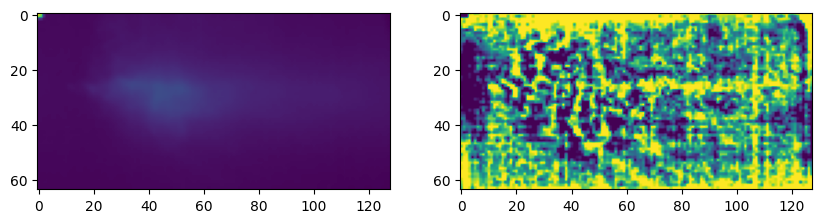

In [5]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional, SemEncoder, MLPSkipNet
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, get_data

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.image_height = 64
args.image_width = 128
args.exclude = []
args.features = ["E","P","ms"]
args.dataset_path = r"data/with_gain"
args.csv_path = "data/params.csv"
args.batch_size = 4
args.latent_dim = 128
args.noise_steps = 700
args.beta_start = 1e-4
args.beta_end = 0.02
device = 'cuda:0'

model = UNet_conditional(img_width=128, img_height=64, feat_num=args.latent_dim, device=device).to(device)
ckpt = torch.load("models/diffAE_transfer/ema_stoch_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=args.noise_steps, section_counts=[20], img_height=64, img_width=128, device=device, rescale_timesteps=False)
model_sem = SemEncoder(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/diffAE_transfer/ema_sem_ckpt.pt", map_location=device)
model_sem.load_state_dict(ckpt)

train_loader = get_data(args)
for data in train_loader:
    images = data['image'].to(device)
    sem = model_sem(images, data['settings'].to(device))
    x = sampler.encode_stochastic(model, images, sem)
    break

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
images = (images.clamp(-1, 1) + 1) / 2
images = (images * 255).type(torch.uint8)
x = (x.clamp(-1, 1) + 1) / 2
x = (x * 255).type(torch.uint8)
ax[0].imshow(images[3].permute(1, 2, 0).cpu())
ax[1].imshow(x[3].permute(1, 2, 0).cpu())

## Reconstruction

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:05<00:00, 10.68it/s]


tensor([[[[  0,   0,   2,  ..., 189, 196, 196],
          [  0,   0,   2,  ..., 189, 196, 196],
          [ 26,  26,  29,  ..., 177, 185, 185],
          ...,
          [224, 224, 224,  ...,  66,  62,  62],
          [247, 247, 247,  ...,  59,  57,  57],
          [247, 247, 247,  ...,  59,  57,  57]]],


        [[[ 15,  15,  37,  ..., 141, 135, 135],
          [ 15,  15,  37,  ..., 141, 135, 135],
          [ 33,  33,  53,  ..., 140, 135, 135],
          ...,
          [ 98,  98, 102,  ..., 187, 180, 180],
          [ 87,  87,  92,  ..., 198, 191, 191],
          [ 87,  87,  92,  ..., 198, 191, 191]]],


        [[[ 15,  15,  40,  ..., 106, 120, 120],
          [ 15,  15,  40,  ..., 106, 120, 120],
          [ 20,  20,  44,  ...,  97, 109, 109],
          ...,
          [ 85,  85, 104,  ..., 131, 133, 133],
          [ 88,  88, 108,  ..., 133, 137, 137],
          [ 88,  88, 108,  ..., 133, 137, 137]]],


        [[[104, 104,  99,  ..., 154, 152, 152],
          [104, 104,  99,  ...,

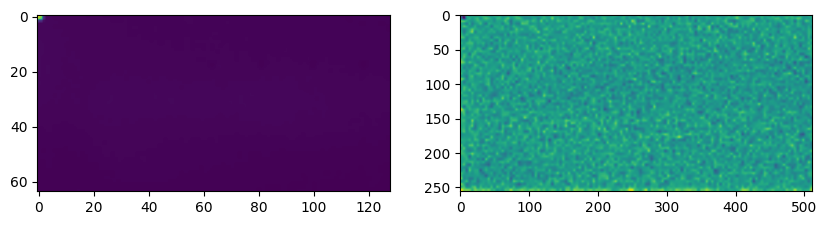

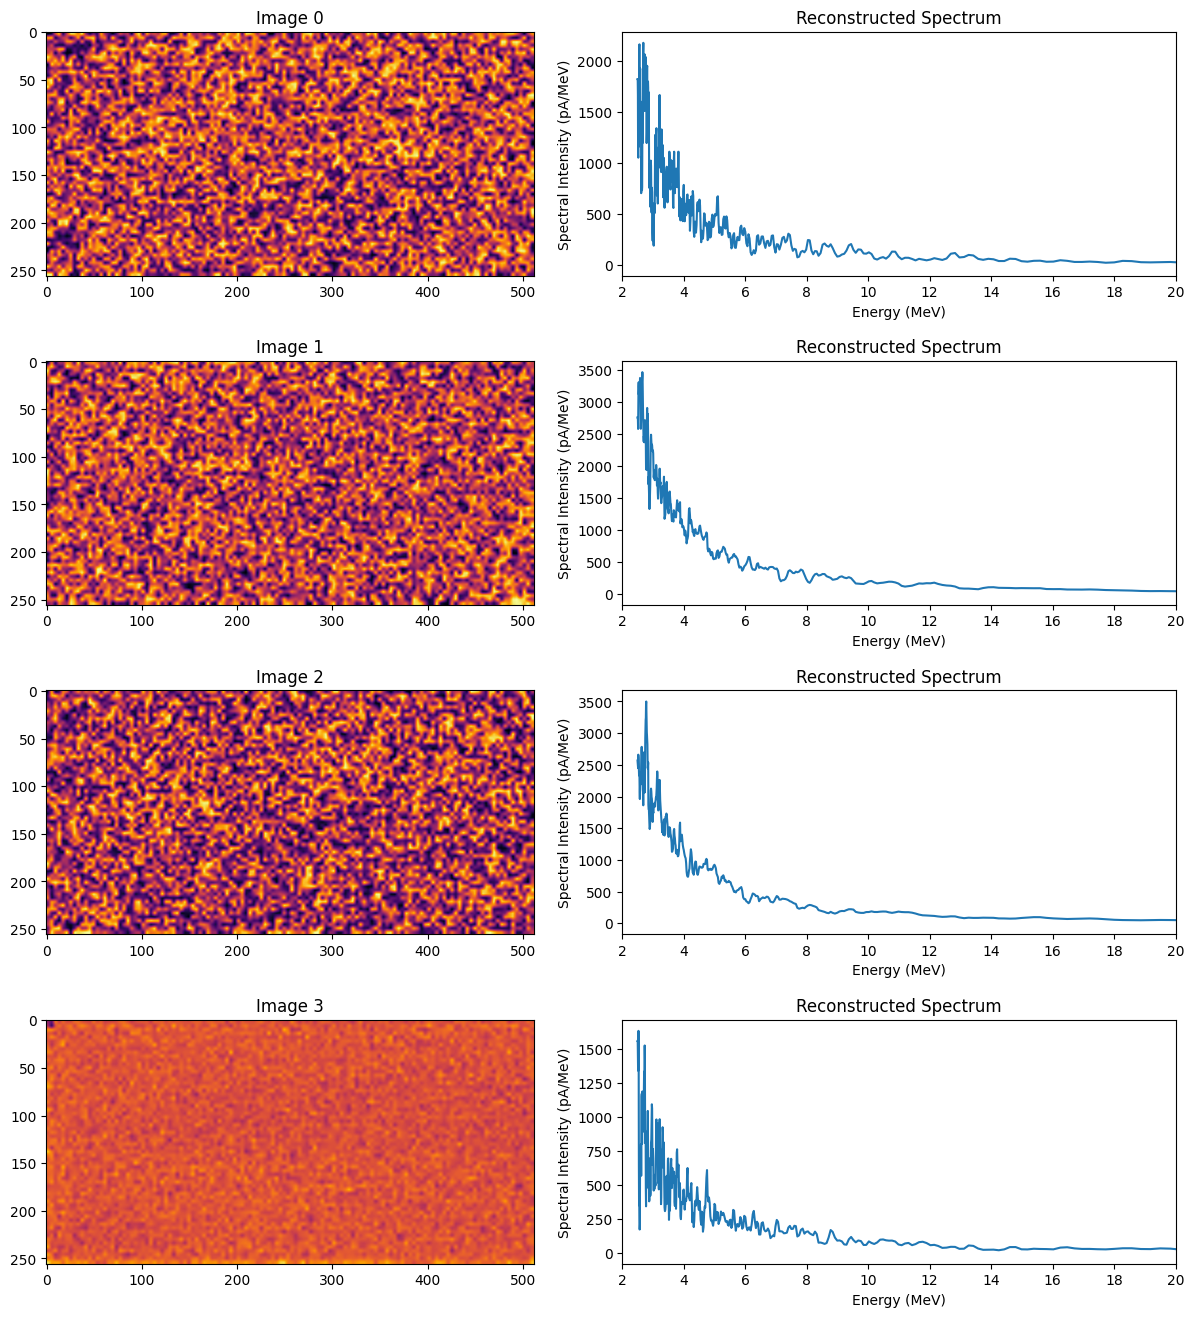

In [2]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional, SemEncoder, MLPSkipNet
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, get_data

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.image_height = 64
args.image_width = 128
args.exclude = []
args.features = ["E","P","ms"]
args.dataset_path = r"data/with_gain"
args.csv_path = "data/params.csv"
args.batch_size = 4
args.latent_dim = 128
args.noise_steps = 700
args.beta_start = 1e-4
args.beta_end = 0.02
device = 'cuda:0'

model = UNet_conditional(img_width=128, img_height=64, feat_num=args.latent_dim, device=device).to(device)
ckpt = torch.load("models/diffAE_transfer/ema_stoch_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=args.noise_steps, section_counts=[20, 10, 30], img_height=64, img_width=128, device=device, rescale_timesteps=False)
model_sem = SemEncoder(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/diffAE_transfer/ema_sem_ckpt.pt", map_location=device)
model_sem.load_state_dict(ckpt)

model.eval()
model_sem.eval()

train_loader = get_data(args)
for data in train_loader:
    images = data['image'].to(device)
    settings = data['settings'].to(device)
    sem = model_sem(images, settings).to(device)
    x = sampler.ddim_sample_loop(model, sem, device=device)
    break

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
images = (images.clamp(-1, 1) + 1) / 2
images = (images * 255).type(torch.uint8)
print(x)
# x = (x.clamp(-1, 1) + 1) / 2
# x = (x * 255).type(torch.uint8)
ax[0].imshow(images[3].permute(1, 2, 0).cpu())
ax[1].imshow(x[3].permute(1, 2, 0).cpu())

plot_image_pairs(x, xlim=[2,20], acquisition_time_ms=20, electron_pointing_pixel=62)